In [21]:
import numpy as np
import cv2
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import os
from brisque import BRISQUE

In [22]:
# enable using OpenEXR with OpenCV
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"

FILE_PATH = os.path.normpath("./data/reference/001.exr")

def read_exr(im_path: str) -> np.ndarray:
    return cv2.imread(
    filename=im_path,
    flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
    )
def tone_map_reinhard(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapReinhard(
    gamma=2.2,
    intensity=0.0,
    light_adapt=0.0,
    color_adapt=0.0
    )
    result = tonemap_operator.process(src=image)
    return result
def tone_map_mantiuk(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapMantiuk(
    gamma=2.2,
    scale=0.85,
    saturation=1.2
    )
    result = tonemap_operator.process(src=image)
    return result

def evaluate_image(image: np.ndarray) -> float:
    metric = BRISQUE(url=False)
    return metric.score(img=image)

def fix_colors(img):
    img = np.clip(img / np.max(img), 0, 1)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


tone_mapped_reinhard 29.354828577541156
tone_mapped_mantiuk 28.249648504374562


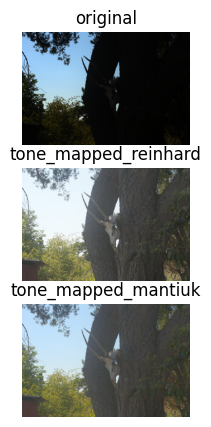

In [23]:
image = read_exr(im_path=FILE_PATH)
tone_mapped_reinhard = tone_map_reinhard(image)
tone_mapped_mantiuk = tone_map_mantiuk(image)

fig, axes = plt.subplots(3, 1, figsize=(10, 5)) 

axes[0].imshow(fix_colors(image))
axes[0].axis('off')
axes[0].set_title("original")

axes[1].imshow(fix_colors(tone_mapped_reinhard))
axes[1].axis('off')
axes[1].set_title("tone_mapped_reinhard")

axes[2].imshow(fix_colors(tone_mapped_mantiuk))
axes[2].axis('off')
axes[2].set_title("tone_mapped_mantiuk")

print('tone_mapped_reinhard', evaluate_image(image=tone_mapped_reinhard))
print('tone_mapped_mantiuk', evaluate_image(image=tone_mapped_mantiuk))

# 3.1 Multiple Exposure Selection

In [24]:
def normalize(img):
    return img * (0.5 / np.mean(img))

def exposure(img: np.ndarray, x):
    return np.clip((2 ** x) * img, 0, 1)

In [25]:
image_hdr = normalize(image)

Text(0.5, 1.0, 'I-e-high')

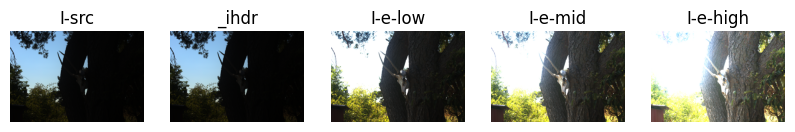

In [26]:
fig, axes = plt.subplots(1, 5, figsize=(10, 10)) 

axes[0].imshow(fix_colors(image))
axes[0].axis('off')
axes[0].set_title("I-src")

axes[1].imshow(fix_colors(image_hdr))
axes[1].axis('off')
axes[1].set_title("_ihdr")

axes[2].imshow(fix_colors(exposure(image_hdr, 1)))
axes[2].axis('off')
axes[2].set_title("I-e-low")

axes[3].imshow(fix_colors(exposure(image_hdr, 2)))
axes[3].axis('off')
axes[3].set_title("I-e-mid")

axes[4].imshow(fix_colors(exposure(image_hdr, 3)))
axes[4].axis('off')
axes[4].set_title("I-e-high")

# 3.2 Tone Mapping Network

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(192, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, stride=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    

class SelfTMO(nn.Module):
    def __init__(self):
        super(SelfTMO, self).__init__()

        # 1 instance of encoder to share the weights
        self.encoder = Encoder()
        
        self.fusion = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3, stride=1),
            nn.Conv2d(192, 192, kernel_size=1, stride=1)
        )

        self.decoder = Decoder()

    def forward(self, exp1, exp2, exp3):
        residual = torch.concat([exp1, exp2, exp3], axis = 3)

        exp1_enc = self.encoder(exp1)
        exp2_enc = self.encoder(exp2)
        exp3_enc = self.encoder(exp3)

        concat = torch.concat([exp1_enc, exp2_enc, exp3_enc], axis = 3)
        
        concat = self.fusion(concat)
        concat = self.decoder(concat)

        return concat + residual

# 3.3 Adaptive μ-law compression

In [30]:
def mi_law(input, lambda1=8.759, lambda2=0.1494, gamma1=2.148, gamma2=-2.067):
    return lambda1 * (input ** gamma1) + lambda2 * (input ** gamma2)

def mi_img(img: np.ndarray):
    law_value = mi_law(img)
    return np.log(1+law_value*img)/np.log(1+law_value)

In [31]:
image_mi = mi_img(image_hdr)

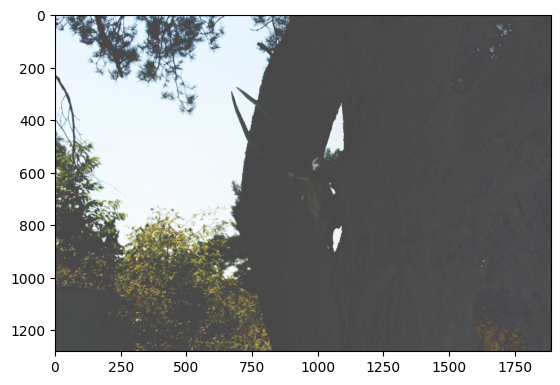

In [33]:
plt.imshow(fix_colors(image_mi))